In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Ploting charts
%matplotlib inline
from glob import glob #retriving an array of files in directories
import cv2
import random
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import r2_score,mean_absolute_error,median_absolute_error,mean_squared_error,mean_squared_log_error
import seaborn as sns 
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.layers import SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing import image
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator   ##Data augmentation and preprocessing
from sklearn.metrics import classification_report
import time
import re
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import gc
import pathlib
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix


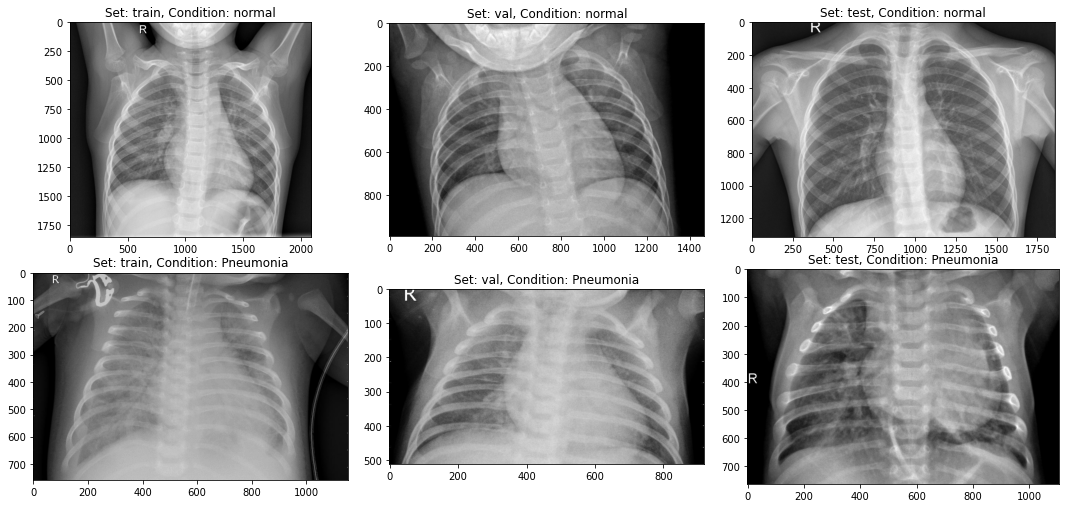

In [2]:
input_path = 'C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

#Generating the list of sample images
for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/normal/'+os.listdir(set_path+'/normal')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/pneumonia/'+os.listdir(set_path+'/pneumonia')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [3]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/normal'))
    n_infect = len(os.listdir(input_path + _set + '/pneumonia'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [4]:
#Image Preprocessing

path_train = "C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/train"
path_val = "C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/val"
path_test = "C:/Users/Acer/OneDrive/Desktop/NEURAL NETWORKS/chest_xray/test"

classes = ["NORMAL", "PNEUMONIA"]
train_data = glob(path_train+"/NORMAL/*.jpeg")
train_data += glob(path_train+"/PNEUMONIA/*.jpeg")
data_gen = ImageDataGenerator() #Augmentation happens here

In [5]:
#DATA AUGMENTATION -
#Performing some data augmentation increases the training data and thus helps in reducing overfitting and gives better results.


def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, shear_range = 0.2, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
# I will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/normal/', '/pneumonia/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/normal/':
                label = 0
            elif cond=='/pneumonia/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [6]:
#We start with defining some of the constants that we will be using during the model creation phase.
img_dims = 150
batch_size = 32

#Now getting the images from the Dataset.
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
#This is a Convolutional Artificial Neural Network
#VGG16 Model
#In between I have used dropouts to reduce over-fitting.
#Activation function was Relu throughout except for the last layer where it was Sigmoid as this is a binary classification problem.
#Before training the model is useful to define one or more callbacks. Pretty handy one, are: ModelCheckpoint and EarlyStopping.



In [7]:
#Creating the architecture of the model.
from keras.layers import  Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import cv2, numpy as np

inputs = Input(shape=(img_dims, img_dims, 3))
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))
x = vgg16_model.output

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

#ADDING OPTIMIZER ADAM
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [8]:
#training the model
# trained the model for 30 epochs with a batch size of 32.
hist = model.fit_generator(
           train_gen, steps_per_epoch=10 // batch_size, 
           epochs=30, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

#We also add ReduceLROnPlateau callback on our model.
#Applying ReduceLROnPlateau reduces the learning rate by a factor of 2-10 once learning stagnates. 
#This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
163/163 [==============================] - 183s 1s/step - loss: 0.3881 - accuracy: 0.8269 - val_loss: 0.6763 - val_accuracy: 0.6299
Epoch 2/30
163/163 [==============================] - 186s 1s/step - loss: 0.3021 - accuracy: 0.8796 - val_loss: 0.7649 - val_accuracy: 0.6201
Epoch 3/30
163/163 [==============================] - 183s 1s/step - loss: 0.2544 - accuracy: 0.9024 - val_loss: 1.1552 - val_accuracy: 0.6283
Epoch 4/30
163/163 [==============================] - 197s 1s/step - loss: 0.2165 - accuracy: 0.9183 - val_loss: 4.8138 - val_accuracy: 0.6299
Epoch 5/30
163/163 [==============================] - 195s 1s/step - loss: 0.2130 - accuracy: 0.9201 - val_loss: 0.6477 - val_accuracy: 0.7204
Epoch 6/30
163/163 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9273
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [========================

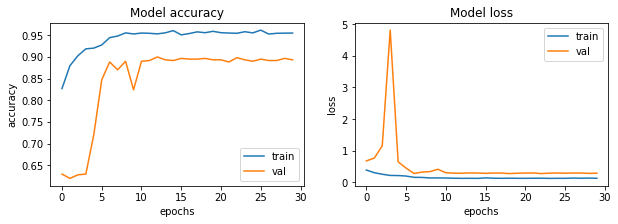

In [9]:
#visualize the loss and accuracy plots.

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [10]:
# ACCURACY AND LOSS FOR VALIDATION
model.evaluate(test_gen)   

20/20 [==============================] - 12s 611ms/step - loss: 0.2886 - accuracy: 0.8910


[0.2886195182800293, 0.8910256624221802]

In [11]:
# ACCURACY AND LOSS FOR TRAIN
model.evaluate(train_gen)

163/163 [==============================] - 162s 995ms/step - loss: 0.1124 - accuracy: 0.9595


[0.11240438371896744, 0.9595475196838379]

In [12]:
import itertools

def Confusion_matrix(cm, classes,normalize=False,title='CONFUSION MATRIX',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


  PERFORMANCE METRICS
Accuracy: 89.42307692307693%
Precision: 87.67441860465117%
Recall: 96.66666666666667%
F1-score: 91.95121951219512


Train acc: 95.48


              precision    recall  f1-score   support

      normal       0.93      0.77      0.85       234
    pnemonia       0.88      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



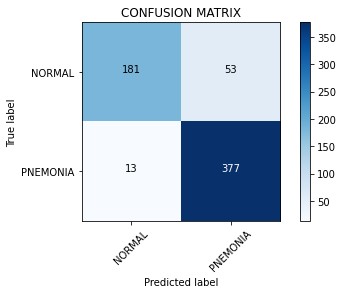

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)


acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('\n  PERFORMANCE METRICS')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))
print()
print()
Confusion_matrix(cm, classes=['NORMAL', 'PNEMONIA'])
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

print()
print()
print(classification_report(test_labels, np.round(preds), target_names=['normal','pnemonia']))

In [14]:
from keras.layers import  Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'signmoid')(x)
model = Model(vgg16_model.input,predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = Adam(lr=0.0002) #learning_rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [26]:
#Changing optimizer from ADAM to RMSprop

from keras.layers import  Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import cv2, numpy as np

inputs = Input(shape=(img_dims, img_dims, 3))
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))
x = vgg16_model.output


# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='tanh', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='tanh', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='tanh')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='tanh')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='tanh')(x)
x = Dropout(rate=0.3)(x)
x = Dropout(rate=0.1)(x)

# Output layer
output = Dense(units=1, activation='softmax')(x)

#ADDING OPTIMIZER RMSprop
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [36]:
from keras.layers import  Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam , RMSprop
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'softmax')(x)
model = Model(vgg16_model.input,predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = RMSprop(lr=0.002) #learning_rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [37]:
#We start with defining some of the constants that we will be using during the model creation phase.
img_dims = 150
batch_size = 40

In [28]:
# trained the model for 35 epochs with a batch size of 40.
hist = model.fit_generator(
           train_gen, steps_per_epoch=8 // batch_size, 
           epochs=35, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])



Epoch 1/35
163/163 [==============================] - 187s 1s/step - loss: 0.3790 - accuracy: 0.8156 - val_loss: 0.6849 - val_accuracy: 0.6234
Epoch 2/35
163/163 [==============================] - 188s 1s/step - loss: 0.3160 - accuracy: 0.8654 - val_loss: 0.6621 - val_accuracy: 0.6266
Epoch 3/35
163/163 [==============================] - 191s 1s/step - loss: 0.2728 - accuracy: 0.8896 - val_loss: 1.2245 - val_accuracy: 0.6266
Epoch 4/35
163/163 [==============================] - 182s 1s/step - loss: 0.2528 - accuracy: 0.8993 - val_loss: 0.3506 - val_accuracy: 0.8668
Epoch 5/35
163/163 [==============================] - 183s 1s/step - loss: 0.2292 - accuracy: 0.9095 - val_loss: 2.8430 - val_accuracy: 0.3750
Epoch 6/35
163/163 [==============================] - 183s 1s/step - loss: 0.2198 - accuracy: 0.9133 - val_loss: 0.2338 - val_accuracy: 0.9112
Epoch 7/35
163/163 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9109
Epoch 00007: ReduceLROnPlateau reducing learni

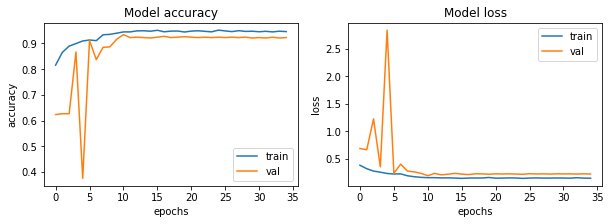

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
# ACCURACY AND LOSS FOR VALIDATION
model.evaluate(test_gen)   

20/20 [==============================] - 7s 351ms/step - loss: 0.2183 - accuracy: 0.9231


[0.2183278650045395, 0.9230769276618958]

In [35]:
# ACCURACY AND LOSS FOR TRAIN
model.evaluate(train_gen)

163/163 [==============================] - 88s 541ms/step - loss: 0.1286 - accuracy: 0.9546


[0.12863437831401825, 0.9545629024505615]